# Graph

## Lightweight adjacency-list

In [10]:
from collections import deque, defaultdict

class Graph:
    def __init__(self, directed: bool = True):
        self.directed = directed
        self.adj = defaultdict(set)   # node -> set of neighbor nodes

    # --- Construction ---
    def add_node(self, u):
        _ = self.adj[u]               # ensures key exists
        return u

    def add_edge(self, u, v):
        self.add_node(u)
        self.add_node(v)
        self.adj[u].add(v)
        if not self.directed:
            self.adj[v].add(u)

    def remove_edge(self, u, v):
        self.adj[u].discard(v)
        if not self.directed:
            self.adj[v].discard(u)

    def remove_node(self, u):
        self.adj.pop(u, None)
        for nbrs in self.adj.values():
            nbrs.discard(u)

    def neighbors(self, u):
        return self.adj[u]

    def has_edge(self, u, v):
        return v in self.adj[u]

    # --- Traversals ---
    def bfs(self, start):
        seen, order = set([start]), []
        q = deque([start])
        while q:
            u = q.popleft()
            order.append(u)
            for v in self.adj[u]:
                if v not in seen:
                    seen.add(v); q.append(v)
        return order

    def dfs(self, start):
        seen, order = set(), []
        stack = [start]
        while stack:
            u = stack.pop()
            if u in seen: 
                continue
            seen.add(u); order.append(u)
            # reverse-sorted for deterministic order (optional)
            for v in sorted(self.adj[u], reverse=True):
                if v not in seen:
                    stack.append(v)
        return order

    # Shortest path in an unweighted graph (BFS parents)
    def shortest_path(self, src, dst):
        if src == dst: 
            return [src]
        parent = {src: None}
        q = deque([src])
        while q:
            u = q.popleft()
            for v in self.adj[u]:
                if v not in parent:
                    parent[v] = u
                    if v == dst:
                        # reconstruct
                        path = [dst]
                        while parent[path[-1]] is not None:
                            path.append(parent[path[-1]])
                        return path[::-1]
                    q.append(v)
        return None  # unreachable

    def __str__(self):
        kind = "Directed" if self.directed else "Undirected"
        lines = [f"{kind} Graph (|V|={len(self.adj)}, |E|={sum(len(n) for n in self.adj.values()) if self.directed else sum(len(n) for n in self.adj.values())//2})"]
        for u in sorted(self.adj, key=lambda x: (str(type(x)), x)):
            nbrs = ", ".join(map(str, sorted(self.adj[u], key=lambda x: (str(type(x)), x))))
            lines.append(f"  {u} -> [{nbrs}]")
        return "\n".join(lines)




In [11]:
g = Graph(directed=True)
g.add_edge(1, 2)
g.add_edge(1, 3)
g.add_edge(2, 4)

print(g)                         # structured adjacency list
# Directed Graph (|V|=4, |E|=3)
#   1 -> [2, 3]
#   2 -> [4]
#   3 -> []
#   4 -> []

print("BFS from 1:", g.bfs(1))   # [1, 2, 3, 4]
print("DFS from 1:", g.dfs(1))   # e.g., [1, 3, 2, 4]
print("1→4 path:", g.shortest_path(1, 4))  # [1, 2, 4]


Directed Graph (|V|=4, |E|=3)
  1 -> [2, 3]
  2 -> [4]
  3 -> []
  4 -> []
BFS from 1: [1, 2, 3, 4]
DFS from 1: [1, 2, 4, 3]
1→4 path: [1, 2, 4]


## Weighted graph variant,store a dict-of-dicts

In [20]:
from collections import defaultdict
import heapq

class WeightedGraph:
    def __init__(self, directed: bool = True):
        self.directed = directed
        self.adj = defaultdict(dict)  # u -> {v: weight}

    def add_node(self, u):
        _ = self.adj[u]; return u

    def add_edge(self, u, v, w=1.0):
        self.add_node(u); self.add_node(v)
        self.adj[u][v] = w
        if not self.directed:
            self.adj[v][u] = w

    def neighbors(self, u):
        return self.adj[u].items()  # iterable of (v, w)

    # Dijkstra (non-negative weights)
    def dijkstra(self, src):
        dist = {u: float("inf") for u in self.adj}
        dist[src] = 0.0
        pq = [(0.0, src)]
        parent = {src: None}
        while pq:
            d, u = heapq.heappop(pq)
            if d != dist[u]: 
                continue
            for v, w in self.adj[u].items():
                nd = d + w
                if nd < dist.get(v, float("inf")):
                    dist[v] = nd
                    parent[v] = u
                    heapq.heappush(pq, (nd, v))
        return dist, parent

    def reconstruct_path(self, parent, dst):
        if dst not in parent: 
            return None
        path = [dst]
        while parent[path[-1]] is not None:
            path.append(parent[path[-1]])
        return path[::-1]

    def __str__(self):
        kind = "Directed" if self.directed else "Undirected"
        lines = [f"{kind} Weighted Graph (|V|={len(self.adj)})"]
        for u in sorted(self.adj, key=lambda x: (str(type(x)), x)):
            nbrs = ", ".join(f"{v}:{w}" for v, w in sorted(self.adj[u].items(), key=lambda kv: (str(type(kv[0])), kv[0])))
            lines.append(f"  {u} -> [{nbrs}]")
        return "\n".join(lines)


In [21]:
wg = WeightedGraph(directed=True)
wg.add_edge("A", "B", 1.2)
wg.add_edge("A", "C", 0.5)
wg.add_edge("C", "B", 0.6)

print(wg)
# Directed Weighted Graph (|V|=3)
#   A -> [B:1.2, C:0.5]
#   B -> []
#   C -> [B:0.6]

dist, parent = wg.dijkstra("A")
print(dist)                         # {'A':0.0, 'B':1.1, 'C':0.5}
print(wg.reconstruct_path(parent, "B"))  # ['A', 'C', 'B']


Directed Weighted Graph (|V|=3)
  A -> [B:1.2, C:0.5]
  B -> []
  C -> [B:0.6]
{'A': 0.0, 'B': 1.1, 'C': 0.5}
['A', 'C', 'B']


## networkx

In [12]:
import networkx as nx

# --- Directed Graph ---
G = nx.DiGraph()   # or nx.Graph() for undirected

# Add nodes
G.add_node("A")
G.add_nodes_from(["B", "C", "D"])

# Add edges
G.add_edge("A", "C")
G.add_edges_from([("B", "C"), ("C", "D")])

# Print nodes and edges
print("Nodes:", G.nodes())
print("Edges:", G.edges())


Nodes: ['A', 'B', 'C', 'D']
Edges: [('A', 'C'), ('B', 'C'), ('C', 'D')]


In [14]:
# trabersals
print("BFS from A:", list(nx.bfs_tree(G, source="A")))
print("DFS from A:", list(nx.dfs_tree(G, source="A")))


BFS from A: ['A', 'C', 'D']
DFS from A: ['A', 'C', 'D']


In [15]:
# Shortest paths
print("Shortest path A → D:", nx.shortest_path(G, source="A", target="D"))
print("Path length:", nx.shortest_path_length(G, "A", "D"))


Shortest path A → D: ['A', 'C', 'D']
Path length: 2


In [16]:
# Cycle detection & Topological sort
print("Has cycle:", not nx.is_directed_acyclic_graph(G))
if nx.is_directed_acyclic_graph(G):
    print("Topological order:", list(nx.topological_sort(G)))


Has cycle: False
Topological order: ['A', 'B', 'C', 'D']


In [17]:
# weighted graphs
WG = nx.DiGraph()
WG.add_weighted_edges_from([
    ("A", "B", 1.2),
    ("A", "C", 0.5),
    ("C", "B", 0.6)
])

print("Dijkstra:", nx.single_source_dijkstra(WG, "A"))


Dijkstra: ({'A': 0, 'C': 0.5, 'B': 1.1}, {'A': ['A'], 'B': ['A', 'C', 'B'], 'C': ['A', 'C']})


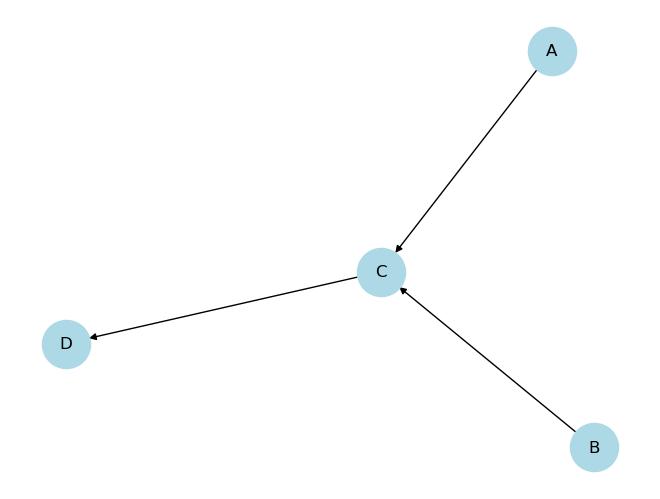

In [19]:
# Visualization
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)  # layout algorithm
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1200, arrows=True)
plt.show()


# Skills

## defaultdic

defaultdic vs dic

dic: 访问不存在的 key, 抛出 KeyError,没有默认值，需要自己判断,通用存储

defaultdic: 访问不存在的 key, 自动创建并赋予默认值, 默认值由工厂函数（int, list, set 等）决定,常用于计数、分组、邻接表等 



In [ ]:
a = dict({"a":123, "b":456})
a["a"]
a["c"] # key errorS

KeyError: 'c'

In [5]:
from collections import defaultdict
d = defaultdict(list)   # 默认值是 list()
d["a"].append(1)        # 自动初始化为 []
print(d["a"])           # [1]
print(d["b"])           # []  （自动创建空列表）

[1]
[]


## deque

deque vs list
deque: double-ended queue

特点：

队列 (queue)：先进先出 (FIFO)

双端 (double-ended)：两端都能高效插入和删除

二、和 list 的区别

在 Python 里，list 虽然也能当队列用，但效率不高：

list.append(x)：在尾部加元素，效率高 (O(1))

list.pop(0)：在头部弹出元素，需要整体移动，效率低 (O(n))

而 deque 在两端操作都是 O(1) 时间复杂度：

append(x)：右端加

appendleft(x)：左端加

pop()：右端弹出

popleft()：左端弹出

list 更适合随机访问

deque 更适合做队列或栈，因为两端操作快

In [7]:
from collections import deque

# 当队列使用（BFS 就用它
q = deque()
q.append("a")       # 入队
q.append("b")
print(q)            # deque(['a', 'b'])

print(q.popleft())  # 出队 -> 'a'
print(q.popleft())  # 出队 -> 'b'


deque(['a', 'b'])
a
b


In [8]:
from collections import deque
# 当栈使用
s = deque()
s.append("x")
s.append("y")
print(s.pop())      # y
print(s.pop())      # x


y
x


In [9]:
from collections import deque
# 限制长度（自动丢弃旧元素）
d = deque(maxlen=3)
d.extend([1,2,3])
print(d)            # deque([1, 2, 3], maxlen=3)
d.append(4)
print(d)            # deque([2, 3, 4], maxlen=3)  # 1 被丢弃


deque([1, 2, 3], maxlen=3)
deque([2, 3, 4], maxlen=3)


## heapq

Python 标准库里的 heapq 提供了一个 最小堆 的实现，底层用 list 存储

一、堆 (Heap) 是什么

堆是一种 特殊的二叉树（完全二叉树，complete binary tree），它满足：

最小堆 (min-heap)：父节点 ≤ 子节点

最大堆 (max-heap)：父节点 ≥ 子节点

所以：

最小堆的 根节点 永远是整个树的最小值

最大堆的 根节点 永远是整个树的最大值

二、堆的主要用途

优先队列 (priority queue)

支持快速取出“最优”（最小/最大）元素

插入和删除都是 O(log n)

取最小/最大元素是 O(1)

排序

Heap Sort 排序就是基于堆实现的

图算法

Dijkstra、Prim、A* 等算法用堆来选出当前“距离最小”的节点

In [23]:
import heapq

pq = []
heapq.heappush(pq, 5)
heapq.heappush(pq, 2)
heapq.heappush(pq, 9)

print(heapq.heappop(pq))  # 2 (最小值)
print(heapq.heappop(pq))  # 5
print(heapq.heappop(pq))  # 9



2
5
9


用heapq 实现最大堆

heapq 库只实现了 min-heap，也就是每次 heappop 取出的都是 最小值。

但是很多时候我们想要 最大堆（取出最大值）。

核心技巧：取负号

数学上：

最大值 ↔ 最小负数

比如：[5, 2, 9]

最大值是 9

取负后 [ -5, -2, -9 ]

最小值是 -9

取负回来就是 9

这样我们就可以用 最小堆来模拟最大堆。


In [24]:
pq = []
heapq.heappush(pq, -5)
heapq.heappush(pq, -2)
heapq.heappush(pq, -9)

print(-heapq.heappop(pq))  # 9 (最大值)
print(-heapq.heappop(pq))  # 5
print(-heapq.heappop(pq))  # 2



9
5
2


如果插入的数字既有负数也有正树，如何取得最大数

为什么有效？

因为堆本质上只会找“最小的数”：

我们插入时取负 → 原来的最大数变成最小负数

堆弹出最小数（负的最大） → 再取负回来 → 就是原来的最大数

即使混合了负数和正数，这个逻辑仍然成立。

总结

在 Python 里要实现 最大堆：

插入时：存 -x

弹出时：取 -heappop()

无论原始数据有没有负数，都能正确取出最大值。

In [ ]:

import heapq

nums = [-7, 3, 10, -2]
pq = []
for x in nums:
    heapq.heappush(pq, -x)   # 存进去的是负数
print(pq) # [-10, 2, -3, 7]
# 此时堆里的内容（内部表示）：[ 7, -3, -10, 2 ]

# 取出时再取负
print(-heapq.heappop(pq))   # 10
print(-heapq.heappop(pq))   # 3
print(-heapq.heappop(pq))   # -2
print(-heapq.heappop(pq))   # -7

[-10, 2, -3, 7]
10
3
-2
-7


visualize heapq

In [ ]:
import heapq
import math

def visualize_heap(heap):
    n = len(heap)
    levels = math.floor(math.log2(n)) + 1 if n > 0 else 0
    i = 0
    for level in range(levels):
        count = 2**level
        row = heap[i:i+count]
        print(" " * (2**(levels-level)) + "  ".join(map(str, row)))
        i += count

# 示例
pq = []
for x in [5, 3, 8, 1, 2, 7]:
    heapq.heappush(pq, x)

print("Heap list:", pq, "\n")
visualize_heap(pq)

# 确实会“歪”，主要是因为：
# 纯文本打印在非等宽字体里会错位；
# 多位数/负号的宽度不一致也会挤歪行距。


Heap list: [1, 2, 7, 5, 3, 8] 

        1
    2  7
  5  3  8
